# GP Regression with Uncertain Inputs

## Introduction

In this notebook, we're going to demonstrate one way of dealing with uncertainty in our training data. Let's say that we're collecting training data that models the following function.

\begin{align}
y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2) 
\end{align}

However, now assume that we're a bit uncertain about our features. In particular, we're going to assume that every `x_i` value is not a point but a distribution instead. E.g.

$$ x_i \sim \mathcal{N}(\mu_i, \sigma_i). $$

### Using a distributional kernel to deal with uncertain inputs

Rather than using a variational method (see the GP Regression with Uncertian Inputs tutorial in the variational examples), if we explicitly know the type of uncertainty in our inputs we can pass that into our kernel.

More specifically, assuming Gaussian inputs, we will compute the symmetrized KL divergence between the Gaussian inputs.



In [1]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

To effectively pass in the training distributional data, we will need to stack the mean and log variances.

In [3]:
train_x_distributional = torch.stack((train_x_mean, (train_x_stdv**2).log()), dim=1)

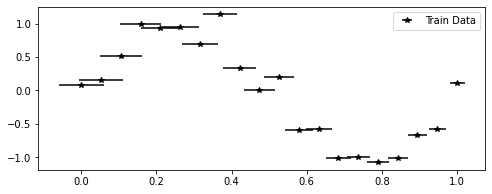

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

We train the hyperparameters of the resulting distributional GP via type-II gradient descent, as is standard in many settings. We could also do fully Bayesian inference.

In [5]:
from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(GaussianSymmetrizedKLKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_distributional, train_y, likelihood)

In [10]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 0.460   lengthscale: 58.355   noise: 0.047
Iter 2/500 - Loss: 0.494   lengthscale: 58.605   noise: 0.037
Iter 3/500 - Loss: 0.461   lengthscale: 58.855   noise: 0.044
Iter 4/500 - Loss: 0.468   lengthscale: 59.105   noise: 0.053
Iter 5/500 - Loss: 0.476   lengthscale: 59.353   noise: 0.057
Iter 6/500 - Loss: 0.467   lengthscale: 59.601   noise: 0.057
Iter 7/500 - Loss: 0.459   lengthscale: 59.849   noise: 0.053
Iter 8/500 - Loss: 0.458   lengthscale: 60.096   noise: 0.049
Iter 9/500 - Loss: 0.461   lengthscale: 60.344   noise: 0.045
Iter 10/500 - Loss: 0.462   lengthscale: 60.592   noise: 0.042
Iter 11/500 - Loss: 0.460   lengthscale: 60.840   noise: 0.041
Iter 12/500 - Loss: 0.455   lengthscale: 61.089   noise: 0.042
Iter 13/500 - Loss: 0.453   lengthscale: 61.338   noise: 0.044
Iter 14/500 - Loss: 0.453   lengthscale: 61.586   noise: 0.047
Iter 15/500 - Loss: 0.454   lengthscale: 61.834   noise: 0.049
Iter 16/500 - Loss: 0.454   lengthscale: 62.081   noise: 0.051
I

Now, we test predictions. For simplicity, we will assume a fixed variance of $0.01.$

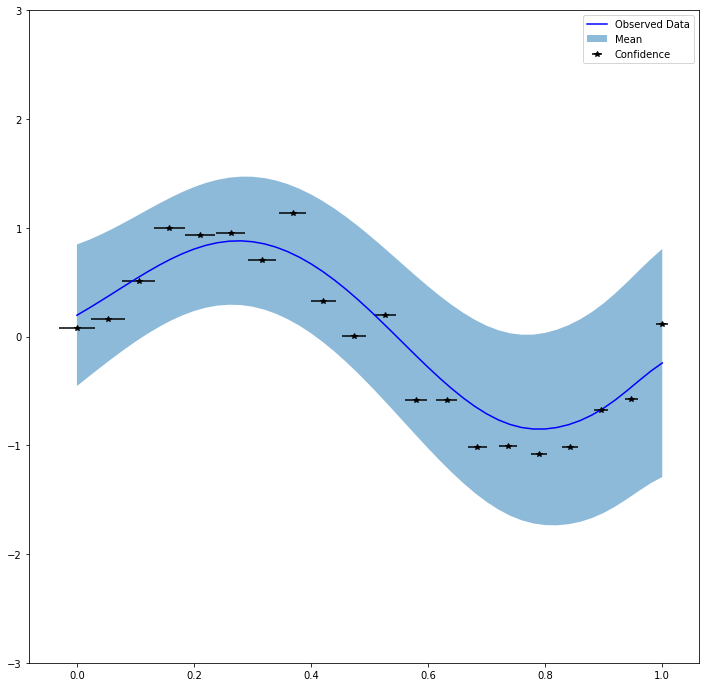

In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    test_x_distributional = torch.stack((test_x, (1e-2 * torch.ones_like(test_x)).log()), dim=1)
    observed_pred = likelihood(model(test_x_distributional))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

As a final note, we've made it very easy to extend the distributional kernel class by exposing a generic `DistributionalInputKernel` class that takes as input any distance function over probability distributions.